In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from classifier import *
from ntk import *
from Q_minimization import *

### Define Dataset

In [3]:
x = np.array([[1, -0.8, -0.5], [1, -0.4, -0.5], [1, 0.15, 0.3]])
y = np.array([[1.0, -1.0, 1.0]]).reshape(-1,)

### Define Dimensions

In [4]:
m = 20
d = 3

### Solve L1

In [5]:
w_0 = np.random.normal(loc=0, scale=1, size=(m, d))
a_0 = np.random.normal(loc=0, scale=1, size=(m,))

In [6]:
w_opt_L1, a_opt_L1 = solver(x, y, w_0, a_0, m, d, obj='L1')
w_opt_L1, a_opt_L1

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 3.9560939539522115
            Iterations: 90
            Function evaluations: 7569
            Gradient evaluations: 90


(array([[ 1.21218734e-03,  5.92678368e-04,  2.58080739e-04],
        [-2.35813363e-03, -8.51795404e-03,  1.54016066e-03],
        [ 1.75036086e-01,  7.97399416e-01, -9.82137346e-01],
        [ 1.60794729e-04,  2.35983196e-03, -2.61760338e-03],
        [ 2.12346327e-01, -1.19923273e+00,  1.38407350e+00],
        [ 8.13187998e-02,  3.68959773e-01, -4.55442734e-01],
        [-2.28978802e-04, -4.88550384e-05,  6.08644959e-05],
        [-2.36035192e-04, -2.60220175e-05, -4.13017502e-05],
        [ 1.65978683e-01,  7.64557240e-01, -9.35507497e-01],
        [ 8.50283562e-04, -5.44950170e-03,  5.98208899e-03],
        [ 8.77588608e-04, -4.92716745e-03,  5.23271326e-03],
        [-9.33986594e-04, -7.69187147e-05, -2.79774592e-05],
        [ 4.84507703e-04, -7.96064609e-05, -8.23790224e-04],
        [ 3.84654723e-05, -9.06194770e-05, -7.72991551e-04],
        [ 5.93104082e-02, -3.30859623e-01,  3.81393934e-01],
        [ 4.08816282e-04, -7.57288877e-04,  5.70188814e-04],
        [ 7.82143695e-02

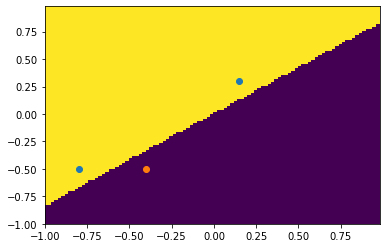

In [7]:
plot_classifier(w_opt_L1, a_opt_L1, x, y)

In [8]:
w_tilde_norms_opt_L1 = calc_w_tilde_norms(w_opt_L1, a_opt_L1)

In [9]:
minimal_margin(w_opt_L1, a_opt_L1, x, y)

0.999999758534738

##### Check condtions are met

In [10]:
margin_constraint(flatten(w_0, a_0), x, y, m, d)

array([-2.65606565,  1.76990222, -3.16429179])

In [11]:
margin_constraint(flatten(w_opt_L1, a_opt_L1), x, y, m, d)

array([-2.41465262e-07, -1.03563115e-07,  3.06393042e-07])

### Create Symmetric Initialization

In [342]:
alpha = 1000
s = 0.8

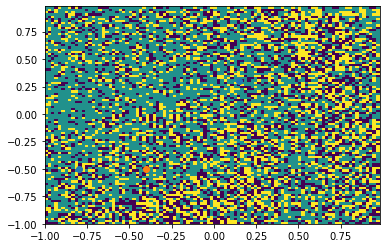

In [343]:
w_0, a_0 = symmetric_init(alpha=alpha, s=s,  m=20, d=3)
plot_classifier(w_0, a_0, x, y)

### Train Full Model

In [272]:
def train(w_0, a_0, alpha, step_size, n_epochs):
    training_accuracy = []
    excess_l1_curve = []

    training_accuracy_Q = []
    excess_l1_Q_curve = []
    s_i = []

    w, a = np.array(w_0), np.array(a_0)

    for epoch in range(n_epochs):
        w, a, gamma_tilde, gamma = update(w, a, x, y, epoch, step_size)

        w_tilde_norms = calc_w_tilde_norms(w, a) / gamma
        excess_l1 = np.linalg.norm(w_tilde_norms, ord=1) / np.linalg.norm(w_tilde_norms_opt_L1, ord=1) - 1
        training_accuracy.append(gamma_tilde)
        excess_l1_curve.append(excess_l1)

        estimate_Q = False
        if (epoch + 1) % 1000 == 0:
            estimate_Q = True
        if (epoch < 100) and (gamma > 0) and ((epoch + 1) % 10 == 0):
            estimate_Q = True
        if estimate_Q:      
            mu = [0.5 * alpha**2 / gamma_tilde] * m
            s_vec = [s] * m
            w_opt_Q, a_opt_Q = solver(
                x,
                y,
                w_0,
                a_0,
                m,
                d,
                obj='Q',
                mu=mu,
                s=s_vec,
                x0=np.random.normal(size=(m * (d + 1),)),
                optim_tol=1e-6)

            _, _, _, gamma = update(w_opt_Q, a_opt_Q.reshape(1, -1), x, y, epoch=0, step_size=0)
            w_tilde_norms_Q = calc_w_tilde_norms(w_opt_Q, a_opt_Q) / gamma

            excess_l1_Q = np.linalg.norm(w_tilde_norms_Q, ord=1) / np.linalg.norm(w_tilde_norms_opt_L1, ord=1) - 1
            excess_l1_Q_curve.append(excess_l1_Q)
            training_accuracy_Q.append(gamma_tilde)
            
    return {
        'w': w,
        'a': a,
        'training_accuracy': training_accuracy,
        'excess_l1_curve': excess_l1_curve,
        'training_accuracy_Q': training_accuracy_Q, 
        'excess_l1_Q_curve': excess_l1_Q_curve
    }

In [376]:
alpha = 1000 

results = {}
for s in [0, 0.8]:
    w_0, a_0 = symmetric_init(alpha=alpha, s=s,  m=20, d=3)
    results[s] = train(w_0, a_0, alpha=alpha, step_size=0.1, n_epochs=10000)

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -511.2789821227119
            Iterations: 21
            Function evaluations: 1724
            Gradient evaluations: 21
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -253.9837706987366
            Iterations: 18
            Function evaluations: 1477
            Gradient evaluations: 18
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -98.14929786134547
            Iterations: 20
            Function evaluations: 1640
            Gradient evaluations: 20
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -87.38734447280966
            Iterations: 18
            Function evaluations: 1476
            Gradient evaluations: 18
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -60.15266543365237
            Iterations: 26
           

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -40.684381000446585
            Iterations: 49
            Function evaluations: 4025
            Gradient evaluations: 49
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -37.31886459559063
            Iterations: 26
            Function evaluations: 2134
            Gradient evaluations: 26
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -43.9473966330766
            Iterations: 33
            Function evaluations: 2716
            Gradient evaluations: 33
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -35.2074532287311
            Iterations: 39
            Function evaluations: 3203
            Gradient evaluations: 39
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -20.87748010506621
            Iterations: 161
           

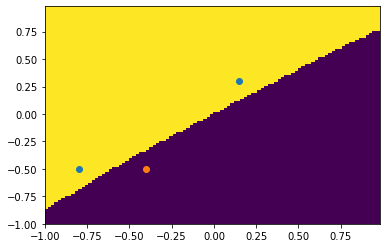

In [413]:
w, a = results[0]['w'], results[0]['a']
plot_classifier(w, a, x, y)

In [414]:
results[0]['training_accuracy'][-1]

20191362.59461297

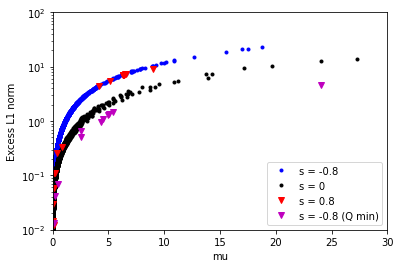

In [421]:
plot([alpha**2/t/2 for t in results[0]['training_accuracy']], results[0]['excess_l1_curve'], 'b.')
plot([alpha**2/t/2 for t in results[0.8]['training_accuracy']], results[0.8]['excess_l1_curve'], 'k.')
plot([alpha**2/t/2 for t in results[0]['training_accuracy_Q']], results[0]['excess_l1_Q_curve'], 'rv')
plot([alpha**2/t/2 for t in results[0.8]['training_accuracy_Q']], results[0.8]['excess_l1_Q_curve'], 'mv')

ylabel('Excess L1 norm')
yscale('log')
ylim([0.01, 100])
xlim([0, 30])
xlabel('mu')
legend([f's = {k}' for k in list(results.keys())] + [f's = {k} (Q min)' for k in results.keys()])

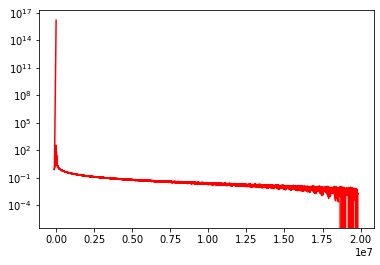

In [418]:
plot(results[-0.8]['training_accuracy'], results[-0.8]['excess_l1_curve'], 'r')
yscale('log')

/Users/shaharazulay/anaconda3/envs/dev/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  # This is added back by InteractiveShellApp.init_path()


Text(0.5, 0, 'Training Accuracy')

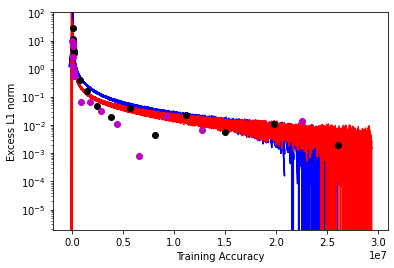

In [331]:
fig, ax1 = plt.subplots()
ax1.set_ylabel('Excess L1 norm', color='k')

ax1.plot(results[0]['training_accuracy'], results[0]['excess_l1_curve'], 'b')
ax1.plot(results[0.8]['training_accuracy'], results[0.8]['excess_l1_curve'], 'r')

ax1.plot(results[0]['training_accuracy_Q'], results[0]['excess_l1_Q_curve'], 'ko')
ax1.plot(results[0.8]['training_accuracy_Q'], results[0.8]['excess_l1_Q_curve'], 'mo')

ax1.set_yscale('log')
ax1.set_ylim([0, 100]);

xlabel('Training Accuracy')

### Compare Different Init Shapes

In [428]:
alpha = 1000
w_0, a_0 = symmetric_init(alpha=alpha, s=0,  m=20, d=3)

s_range = [0, 0.5, 0.8, 0.9, 0.99]
mu_range = [0.01, 0.05, 0.1, 0.25, 0.5, 1, 2, 3, 5, 10, 20]

In [429]:
excess_l1_Q_curve = {}

for s_val in s_range:
    for mu_val in mu_range:
        mu = [mu_val] * m
        s_vec = [s_val] * m
        
        w_opt_Q, a_opt_Q = solver(x, y, w_0, a_0, m, d, obj='Q', mu=mu, s=s_vec, x0=np.random.normal(size=(m * (d + 1),)))
        _, _, _, gamma = update(w_opt_Q, a_opt_Q.reshape(1, -1), x, y, epoch=0, step_size=0)
        w_tilde_norms_Q = calc_w_tilde_norms(w_opt_Q, a_opt_Q) / gamma
        
        excess_l1_Q = np.linalg.norm(w_tilde_norms_Q, ord=1) / np.linalg.norm(w_tilde_norms_opt_L1, ord=1) - 1
        excess_l1_Q_curve.setdefault(s_val, []).append(excess_l1_Q)

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 14.085550933410051
            Iterations: 173
            Function evaluations: 14587
            Gradient evaluations: 173
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 7.7786146398261735
            Iterations: 202
            Function evaluations: 16978
            Gradient evaluations: 202
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 4.526216302299205
            Iterations: 376
            Function evaluations: 31777
            Gradient evaluations: 375
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.3953030630947842
            Iterations: 240
            Function evaluations: 20415
            Gradient evaluations: 240
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -0.9784387688151986
            Iterations: 14

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -17.735724120818645
            Iterations: 105
            Function evaluations: 8709
            Gradient evaluations: 105
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -27.042875936806407
            Iterations: 163
            Function evaluations: 13623
            Gradient evaluations: 163
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -45.21609105269742
            Iterations: 142
            Function evaluations: 11831
            Gradient evaluations: 142
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -90.49999918782048
            Iterations: 26
            Function evaluations: 2133
            Gradient evaluations: 26
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -180.9999998586397
            Iterations: 25
 

/Users/shaharazulay/anaconda3/envs/dev/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  


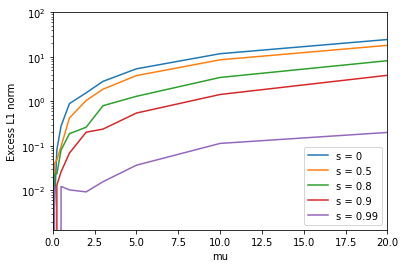

In [430]:
for k in excess_l1_Q_curve.keys():
    plot(mu_range, excess_l1_Q_curve[k])

ylabel('Excess L1 norm')
yscale('log')
ylim([0, 100])
xlim([0, 20])
xlabel('mu')
legend([f's = {k}' for k in excess_l1_Q_curve.keys()])